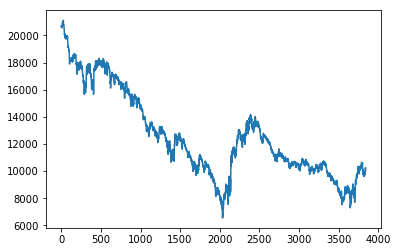

In [1]:
# Outlook on the Close trend
import pandas as pd
import matplotlib.pyplot as plt
dataframe = pd.read_csv('DJI.csv', usecols=['Close'], index_col=False)
plt.plot(dataframe)
plt.show()

## Preprocessing

In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from sklearn import svm
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
# Convert values into float, which is better for NN
dataset = dataframe.values
dataset = dataset.astype('float32')

In [4]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#### With time series data, the sequence of values is important.

In [5]:
# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(2574, 1269)


In [6]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

## SVM

In [11]:
# Use grid search cross-validation to find the best parameters
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
              'C':np.arange(0.1, 2, 0.1)}
svr = svm.SVR()
clf = GridSearchCV(svr, parameters, cv=3)
clf.fit(trainX, trainY)
print("Best estimator: ", clf.best_estimator_)

('Best estimator: ', SVR(C=1.3000000000000003, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False))


In [18]:
svr = clf.best_estimator_
svr.fit(trainX, trainY)

svrTrainScore = mean_squared_error(trainY, svrTrain)
svrTestScore = mean_squared_error(testY, svrTest)

print("Train score = ", svrTrainScore)
print("Test score = ", svrTestScore)

('Train score = ', 10.015047845519243)
('Test score = ', 10.64519664370502)


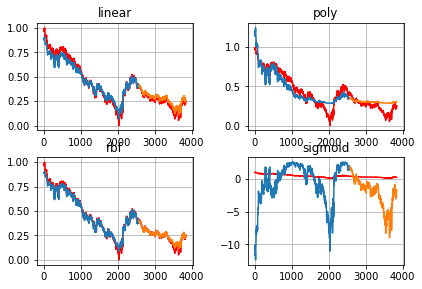

-------Ordered RMSE-------
(0.00028405406616994702, 'rbf')
(0.00094242390848725988, 'linear')
(0.0069101882809041891, 'poly')
(10.64519664370502, 'sigmoid')


In [8]:
sub = 221
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
testErrors = []
plt.figure(1)

for k in kernels:
    # Train the Support Vector Regression
    clf = svm.SVR(kernel=k)
    clf.fit(trainX, trainY)
    # Predictions
    svrTrain = clf.predict(trainX)
    svrTest = clf.predict(testX)
    # Calculate mean squared error
    svrTrainScore = mean_squared_error(trainY, svrTrain)
    svrTestScore = mean_squared_error(testY, svrTest)
    testErrors.append((svrTestScore, k))
    # plot baseline and predictions
    plt.subplot(sub)
    plt.plot(dataset, color='r')
    plt.plot(svrTrain)
    xPlot = np.arange(len(svrTrain)+(look_back*2)+1,len(dataset)-1)
    plt.plot(xPlot, svrTest)
    plt.title(k)
    plt.grid(True)
    sub += 1
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

testErrors.sort()
print("-------Ordered RMSE-------")
for e in testErrors:
    print e

## LSTM Model
##### The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [14]:
# Reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Knowing last previous value

In [15]:
# Building the NN using Keras
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
# Train the model
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
21s - loss: 0.0304
Epoch 2/10
23s - loss: 1.3961e-04
Epoch 3/10
18s - loss: 1.1976e-04
Epoch 4/10
17s - loss: 1.2447e-04
Epoch 5/10
18s - loss: 1.2694e-04
Epoch 6/10
17s - loss: 1.2155e-04
Epoch 7/10
18s - loss: 1.2348e-04
Epoch 8/10
19s - loss: 1.2054e-04
Epoch 9/10
18s - loss: 1.2245e-04
Epoch 10/10
19s - loss: 1.2025e-04


In [17]:
# Predict
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [18]:
# Rescale predictions (to ensure mse calculation is right)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [40]:
# Evaluation of the model 

print('------MAE-------')
maeTrainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (maeTrainScore))
maeTestScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (maeTestScore))

print('------RMSE------')
rmseTrainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (rmseTrainScore))
rmseTestScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (rmseTestScore))

------MAE-------
Train Score: 108.86 MAE
Test Score: 75.42 MAE
------RMSE------
Train Score: 149.44 RMSE
Test Score: 100.64 RMSE


In [20]:
# Prepare the data to be plot

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

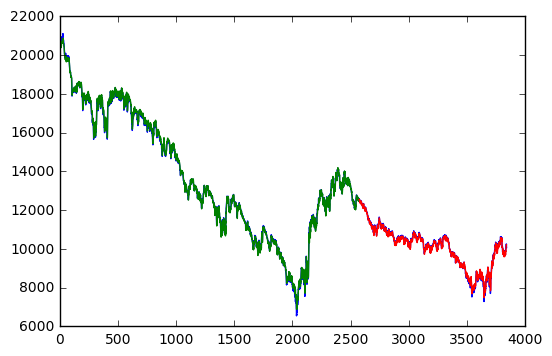

In [21]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Window method

In [108]:
# Same than before but this time let us choose a window of 3
look_back = 3
wTrainX, wTrainY = create_dataset(train, look_back)
wTestX, wTestY = create_dataset(test, look_back)

In [109]:
# Reshape input to be [samples, time steps, features]
wTrainX = numpy.reshape(wTestX, (wTestX.shape[0], 1, wTestX.shape[1]))
wTestX = numpy.reshape(wTestX, (wTestX.shape[0], 1, wTestX.shape[1]))

In [110]:
# create and fit the LSTM network
wModel = Sequential()
wModel.add(LSTM(4, input_shape=(1, look_back)))
wModel.add(Dense(1))
wModel.compile(loss='mean_squared_error', optimizer='adam')

In [111]:
# Train the model
wModel.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
21s - loss: 0.0218
Epoch 2/10
22s - loss: 2.6845e-04
Epoch 3/10
22s - loss: 2.1011e-04
Epoch 4/10
18s - loss: 1.8132e-04
Epoch 5/10
18s - loss: 1.6229e-04
Epoch 6/10
18s - loss: 1.5716e-04
Epoch 7/10
19s - loss: 1.5161e-04
Epoch 8/10
19s - loss: 1.4514e-04
Epoch 9/10
19s - loss: 1.4258e-04
Epoch 10/10
21s - loss: 1.4009e-04


In [112]:
# Predict
wTrainPredict = model.predict(trainX)
wTestPredict = model.predict(testX)

In [113]:
# Rescale predictions (to ensure mse calculation is right)
wTrainPredict = scaler.inverse_transform(wTrainPredict)
wTrainY = scaler.inverse_transform([wTrainY])
wTestPredict = scaler.inverse_transform(wTestPredict)
wTestY = scaler.inverse_transform([wTestY])

In [41]:
# Evaluation of the model 

print('------MAE-------')
maeTrainScore = mean_absolute_error(wTrainY[0], wTrainPredict[:,0])
print('Train Score: %.2f MAE' % (maeTrainScore))
maeTestScore = mean_absolute_error(wTestY[0], wTestPredict[:,0])
print('Test Score: %.2f MAE' % (maeTestScore))

print('------RMSE------')
rmseTrainScore = math.sqrt(mean_squared_error(wTrainY[0], wTrainPredict[:,0]))
print('Train Score: %.2f RMSE' % (rmseTrainScore))
rmseTestScore = math.sqrt(mean_squared_error(wTestY[0], wTestPredict[:,0]))
print('Test Score: %.2f RMSE' % (rmseTestScore))

------MAE-------
Train Score: 108.86 MAE
Test Score: 75.42 MAE
------RMSE------
Train Score: 149.44 RMSE
Test Score: 100.64 RMSE


In [115]:
# Prepare the data to plot

# shift train predictions for plotting
wTrainPredictPlot = numpy.empty_like(dataset)
wTrainPredictPlot[:, :] = numpy.nan
wTrainPredictPlot[look_back:len(wTrainPredict)+look_back, :] = wTrainPredict
# shift test predictions for plotting
wTestPredictPlot = numpy.empty_like(dataset)
wTestPredictPlot[:, :] = numpy.nan
wTestPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = wTestPredict

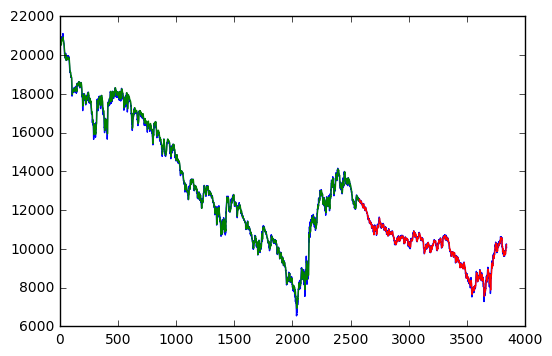

In [116]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(wTrainPredictPlot)
plt.plot(wTestPredictPlot)
plt.show()

Resources :
http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ 